#  Analysis of leaf chamber experiments
This worksheet produces figures for:

**Leaf-scale experiments reveal important omission in the Penman-Monteith equation**

Schymanski, S.J. and D. Or

http://www.hydrol-earth-syst-sci-discuss.net/hess-2016-363/

Author: Stan Schymanski (stan.schymanski@env.ethz.ch)

## Worksheet setup and importing equations and functions from other worksheets

In [1]:
%%capture storage
# The above redirects all output of the below commands to the variable 'storage' instead of displaying it.
# It can be viewed by typing: 'storage()'

# Setup of worksheet, incl. importing of packages and defining general custom functions
load('temp/Worksheet_setup.sage')
from shutil import copyfile   # for copying files between directories
from matplotlib.ticker import MaxNLocator
import csv
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# From leaf_chamber_eqs, Leaf_enbalance2s_eqs and E_PM_eqs
load_session('temp/leaf_enbalance_eqs.sobj')
dict_vars1 = dict_vars.copy()

load_session('temp/E_PM_eqs.sobj')
dict_vars1.update(dict_vars)

load_session('temp/leaf_chamber_eqs.sobj')
dict_vars1.update(dict_vars)

dict_vars = dict_vars1.copy()
fun_loadvars(vardict=dict_vars)   # re-loading variable definitions

In [3]:
path_figs = 'figures/'
path_data = 'data/'
path_data_orig = '/home/sschyman/Documents/STEP/Lab_data/leaf_chamber/'

## Functions to compute steady-state leaf energy balance components

In [4]:
def fun_SS(vdict1):
    '''
    Steady-state T_l, R_ll, H_l and E_l under forced conditions.
    Parameters are given in a dictionary (vdict) with the following entries:
    a_s, a_sh, L_l, P_a, P_wa, R_s, Re_c, T_a, g_sw, v_w
    ''' 
    vdict = vdict1.copy()
    if not T_w in vdict1.keys():
        vdict[T_w] = vdict[T_a]


    # Nusselt number
    vdict[nu_a] = eq_nua.rhs().subs(vdict)
    vdict[Re] = eq_Re.rhs().subs(vdict)
    vdict[Nu] = eq_Nu_forced_all.rhs().subs(vdict)
    
    # h_c
    vdict[k_a] = eq_ka.rhs().subs(vdict)
    vdict[h_c] = eq_hc.rhs().subs(vdict)
 
    # gbw
    vdict[D_va] = eq_Dva.rhs().subs(vdict)
    vdict[alpha_a] = eq_alphaa.rhs().subs(vdict)
    vdict[rho_a] =  eq_rhoa.rhs().subs(vdict)
    vdict[Le] =  eq_Le.rhs().subs(vdict)
    vdict[g_bw] = eq_gbw_hc.rhs().subs(vdict)   
    
    # Hl, Rll
    vdict[R_ll] = eq_Rll.rhs().subs(vdict)
    vdict[H_l] = eq_Hl.rhs().subs(vdict)   

    # El
    vdict[g_tw] =  eq_gtw.rhs().subs(vdict)
    vdict[C_wa] = eq_Cwl.rhs()(P_wl = P_wa, T_l = T_a).subs(vdict)
    vdict[P_wl] = eq_Pwl.rhs().subs(vdict)
    vdict[C_wl] = eq_Cwl.rhs().subs(vdict)
    vdict[E_lmol] = eq_Elmol.rhs().subs(vdict)
    vdict[E_l] = eq_El.rhs().subs(eq_Elmol).subs(vdict)    

    # Tl
    try: vdict[T_l] = find_root((eq_Rs_enbal - R_s).rhs().subs(vdict), 273, 373)
    except: print 'something missing: ' + str((eq_Rs_enbal - R_s).rhs().subs(vdict))
    
    # Re-inserting T_l
    Tlss = vdict[T_l]
    for name1 in [C_wl, P_wl, R_ll, H_l, E_l, E_lmol]:
        vdict[name1] = vdict[name1].subs(T_l = Tlss)
    
    # Test for steady state
    if n((E_l + H_l + R_ll - R_s).subs(vdict))>1.:
        return 'error in energy balance: El + Hl + Rll - R_s = ' + str(n((E_l + H_l + R_ll - R_s).subs(vdict))) 
    return vdict

In [5]:
# Test using data from Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40
vdict[v_w] = 1.
resdict = fun_SS(vdict)

dict_print(resdict, list_names = [H_l, E_l, T_l])

E_l             180.542235053942
H_l             150.521099595469
T_l             308.321395271  


### Model by Ball et al., 1988

In [6]:
# for model by Ball et al. 1988
var2('g_svmol', 'Stomatal condutance to vapour in molar units', mole/meter^2/second)
var2('c_pmol', 'Molar heat capacity of air', value = 29.2, units = joule/mole/kelvin)   # Units in the appendix are wrongly given as J mol/K
var2('L_E', 'Latent heat of vaporisation of water', value = 44000, units = joule/mole)
var2('r_bstar', 'Boundary layer resistance to heat transfer from unit area of leaf', meter^2*second/mole)
var2('r_b', 'Boundary layer resistnace to vapour transfer', meter^2*second/mole)
var2('r_s', 'Stomatal resistance to vapour transfer', meter^2*second/mole)

eq_Hl_Ball = H_l == c_pmol*(T_l - T_a)/r_bstar
eq_El_Ball = E_l == L_E*(P_wl - P_wa)/P_a/(r_s + r_b)
eq_rbstar = r_bstar == (3.8*L_A^(1/4)*v_w^(-1/2))
eq_rb = r_b == (1.78/a_s*r_bstar)
print units_check(eq_Hl_Ball).simplify_full()
print units_check(eq_El_Ball).simplify_full()

H_l == -(T_a - T_l)*c_pmol/r_bstar

kilogram/second^3 == kilogram/second^3


E_l == -L_E*(P_wa - P_wl)/(P_a*(r_b + r_s))

kilogram/second^3 == kilogram/second^3


In [7]:
def fun_SS_Ball(vdict1):
    '''
    Steady-state T_l, h_c, g_bv, g_tv, R_ll, H_l and E_l under forced conditions.
    h_c and g_bv are calculated using Appendix in Ball et al. (1988).
    see Ball_1988_Maintenance_of_Leaf2.pdf
    Parameters are given in a dictionary (vdict) with the following entries:
    a_s, L_l, P_a, P_wa, R_s, Re_c, T_a, g_svmol, v_w
    ''' 
    vdict = vdict1.copy()
    if not L_A in vdict.keys():
        vdict[L_A] = (pi()*L_l^2).subs(vdict)
    if not T_w in vdict.keys():
        vdict[T_w] = vdict[T_a]

    vdict[r_s] = (1/(40*g_sw)).subs(vdict)
    try:
        vdict[r_bstar] = eq_rbstar.rhs().subs(vdict).n()   #two-sided resistance for sensible heat flux
    except:
        vdict[r_bstar] = eq_rbstar.rhs().subs(vdict)
        print 'r_bstar = ' + str(vdict[r_bstar])
    vdict[r_b] = eq_rb.rhs().subs(vdict)             # one-sided resistance to latent heat flux
    
    
    
    Rll = eq_Rll.rhs().subs(vdict)
    Hl = eq_Hl_Ball.rhs().subs(vdict)
    El = eq_El_Ball.rhs().subs(eq_Pwl).subs(vdict)
    
    enbal = El + Hl + Rll - R_s == 0 
    #print enbal(R_ll = Rll, H_l = Hl, E_l = El).subs(vdict)
    Tss = find_root(enbal(R_ll = Rll, H_l = Hl, E_l = El).subs(vdict), 273, 373)
    
    Rll1 = Rll(T_l = Tss)
    Hl1= Hl(T_l = Tss)
    El1 = El(T_l = Tss)

    # Test for steady state
    if (El1 + Hl1 + Rll1 - vdict[R_s])>1.:
        print (El, Hl, Rll, vdict[R_s])
        print Tss
        return 'error in energy balance'
    Pwl = eq_Pwl.rhs()(T_l = Tss).subs(vdict)
    
    #dict_print(vdict)
    return {'Tl_ball':n(Tss), 'Rll_ball':n(Rll1), 'Hl_ball':n(Hl1), 'El_ball':n(El1), 'rs_ball': vdict[r_s], 'rbstar_ball': vdict[r_bstar], 'rb_ball': vdict[r_b]}

In [8]:
# Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40

vdict[v_w] = 1.
ssdict = fun_SS(vdict)
#print ssdict
balldict = fun_SS_Ball(vdict)
#print balldict
print 'h_c(Ball): ' + str((c_pmol/balldict['rbstar_ball']).subs(vdict))
print 'g_vmol(Ball): ' + str((1/(r_b + r_s))(r_b = balldict['rb_ball'], r_s = balldict['rs_ball']))
print 'g_vmol(SS): ' + str(eq_gtwmol_gtw(T_l = T_a).subs(eq_gtw).subs(ssdict).subs(vdict))
print 'T_l(Ball): ' + str(balldict['Tl_ball'])
print 'T_l(SS): ' + str(ssdict[T_l])
print 'T_a: ' + str(vdict[T_a])

h_c(Ball): 21.8153792127944
g_vmol(Ball): 0.110506932339455
g_vmol(SS): g_twmol == 0.117381005752392
T_l(Ball): 309.125596874492
T_l(SS): 308.321395271
T_a: 303


<p><span style="color: #ff0000;">According to Fig. 8 in Ball et al., 1988, steady-state leaf temperature should be higher by 10 K than air temperature! Here it is only 6. <br /></span></p>

### Analytical models

In [9]:
def fun_SS_PM(vdict1):
    '''
   Analytical equations from Worksheet E_PM_eqs, including detailed steady-state.
    '''
    vdict = vdict1.copy()
    if not L_A in vdict1.keys():
        vdict[L_A] = (pi()*L_l^2).subs(vdict1)
    if not T_w in vdict1.keys():
        vdict[T_w] = vdict[T_a]
    if not P_wa in vdict1.keys():
        print 'P_wa is missing'
    ss = fun_SS(vdict)

    vdict[P_was] = eq_Pwl.rhs()(T_l = T_a).subs(vdict) 
    vdict[Delta_eTa] = eq_Deltaeta_T.rhs().subs(vdict)
    vdict[k_a] = eq_ka.rhs().subs(vdict)
    vdict[nu_a] = eq_nua.rhs().subs(vdict)
    vdict[Re] = eq_Re.rhs().subs(vdict)
    vdict[Nu] = eq_Nu_forced_all.rhs().subs(vdict)
    vdict[h_c] = eq_hc.rhs().subs(vdict) 
    
    vdict[P_N2] = eq_PN2.rhs().subs(vdict)
    vdict[P_O2] = eq_PO2.rhs().subs(vdict)
    vdict[alpha_a] = eq_alphaa.rhs().subs(vdict)
    vdict[k_a] = eq_ka.rhs().subs(vdict)
    vdict[D_va] = eq_Dva.rhs().subs(vdict)
    vdict[Le] = eq_Le.rhs().subs(vdict)
    vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs().subs(vdict) 
    vdict[g_bw] = eq_gbw_hc.rhs().subs(vdict)
    vdict[g_tw] = eq_gtw.rhs().subs(vdict)
    vdict[g_twmol] = eq_gtwmol_gtw_iso.rhs().subs(vdict)

    # Generalized Penman, getting Rll first
    vdict_GPRll = vdict.copy()
    vdict_GPRll[R_ll] = 0.
    vdict_GPRll[T_l] = eq_Tl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GPRll)
    vdict_GPRll[R_ll] = eq_Rll.rhs().subs(vdict_GPRll)
    vdict_GPRll[E_l] = eq_El_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GPRll)
    vdict_GPRll[H_l] = eq_Hl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GPRll)


    # Using linearised R_ll solution
    vdict_lin = vdict.copy()
    namesdict = [E_l, H_l, T_l, R_ll]
    vdict_lin[E_l] = eq_El_Delta_Rlllin.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_lin)
    vdict_lin[H_l] = eq_Hl_Delta_Rlllin.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_lin)
    vdict_lin[T_l] = eq_Tl_Delta_Rlllin.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_lin)
    vdict_lin[R_ll] = eq_Rll_tang.rhs().subs(vdict_lin)


    # 'R_N = R_s:' MU-book, P. 79, under cloudy skies, implying that R_ll = 0
    vdict2 = vdict.copy()
    vdict2[R_ll] = 0
    
    # Generalized Penman
    vdict_GP = vdict2.copy()
    vdict_GP[E_l] = eq_El_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GP)
    vdict_GP[H_l] = eq_Hl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GP)
    vdict_GP[T_l] = eq_Tl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GP)


    # Penman-stomata
    vdict_PS = vdict2.copy()
    vdict_PS[S] = eq_S_gbw_gsw.rhs().subs(vdict_PS)
    vdict_PS[f_u] = eq_fu_gbw.rhs().subs(vdict_PS)
    vdict_PS[gamma_v] = eq_gammav_as.rhs().subs(vdict_PS)
    vdict_PS[E_l] = eq_El_P52.rhs().subs(vdict_PS)
    vdict_PS[H_l] = eq_Hl_P52.rhs().subs(vdict_PS)
    vdict_PS[T_l] = eq_Tl_P52.rhs().subs(vdict_PS)
    
    # PM equation
    vdict_PM = vdict2.copy() 
    vdict_PM[r_s] = 1/vdict_PM[g_sw]
    vdict_PM[r_a] = eq_ra_hc.rhs().subs(vdict_PM)
    vdict_PM[gamma_v] = eq_gammav_MU.rhs().subs(vdict_PM)
    vdict_PM[epsilon] = eq_epsilon.rhs().subs(vdict_PM)
    vdict_PM[E_l] = eq_El_PM2.rhs().subs(vdict_PM)
    vdict_PM[H_l] = (R_s - R_ll - E_l).subs(vdict_PM)
    
    # MU equation
    vdict_MU = vdict2.copy() 
    vdict_MU[n_MU] = (a_sh/a_s).subs(vdict_MU)
    vdict_MU[r_s] = 1/vdict_MU[g_sw]
    vdict_MU[r_a] = eq_ra_hc.rhs().subs(vdict_MU)
    vdict_MU[gamma_v] = eq_gammav_MU.rhs().subs(vdict_MU)
    vdict_MU[E_l] = eq_El_MU2.rhs().subs(vdict_MU)
    vdict_MU[H_l] = (R_s - R_ll - E_l).subs(vdict_MU)
    
    # 'Corrected MU-equation: '
    vdict_MUc = vdict2.copy()
    vdict_MUc[r_s] = 1/vdict_MUc[g_sw]
    vdict_MUc[r_a] = eq_ra_hc.rhs().subs(vdict_MUc)    
    vdict_MUc[gamma_v] = eq_gammav_MU.rhs().subs(vdict_MUc)
    vdict_MUc[E_l] = eq_El_MU_corr.rhs().subs(vdict_MUc)
    vdict_MUc[H_l] = (R_s - R_ll - E_l).subs(vdict_MUc)

    resdict = ss.copy()
    str1 = 'GPRll'
    namesdict = [E_l, H_l, T_l, R_ll]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]    
    
    str1 = 'lin'
    namesdict = [E_l, H_l, T_l, R_ll]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]

    str1 = 'GP'
    namesdict = [E_l, H_l, T_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]

    str1 = 'PS'
    namesdict = [E_l, H_l, T_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]    

    str1 = 'PM'
    namesdict = [E_l, H_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]

    str1 = 'MU'
    namesdict = [E_l, H_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]        

    str1 = 'MUc'
    namesdict = [E_l, H_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]
            
    return resdict

# Data reading, computing and display functions

## Functions to read data

In [10]:
def fun_read_csv(fname1, lc_datetime_format = "%Y-%m-%d %H:%M:%S", lc_timepos = [], split1 = ';'):
    '''
    Reads file written by leaf_chamber_read_data and saves them as lc_data
    If csv file fname1 does not exist in path_data, copies the file from path_data_orig to path_data
    before opening and reading into numpy array. Contents of data file are printed as table before returning numpy array.
    '''
    lc_timepos = lc_timepos[:]
    fname = path_data + fname1
    try:
        reader = csv.reader(open(fname, 'r'), delimiter=split1, quotechar='"')
    except:
        copyfile(path_data_orig + fname1, fname)
        reader = csv.reader(open(fname, 'r'), delimiter=split1, quotechar='"')
    htmldata = []
    lc_nameslist = reader.next()
    htmldata.append(lc_nameslist)
    htmldata[-1][-1] = htmldata[-1][-1]+ '...................................................'  # To avoid very thick rows
    #print htmldata
    lc_formatslist = ['S200' for i in srange(len(lc_nameslist))]
    lc_unitslist = reader.next()
    htmldata.append(lc_unitslist)
    #print lc_unitslist
    #print reader.next()
    ncols = len(lc_nameslist)
    lc_datetime_format = "%Y-%m-%d %H:%M:%S"
    csvdata = []
    with open(fname, 'r') as file_out:
        rows = file_out.readlines()
       
    # Determining dtypes
    for row in rows[2:]:
        row1 = row.strip('\r\n').split(split1)
        for i in srange(len(row1)-1):
            try:
                blah = float(row1[i])
                lc_formatslist[i] = 'float'
            except:
                try:
                    blah = datetime.datetime.fromtimestamp(time.mktime(time.strptime(row1[i].strip(), lc_datetime_format)))
                    lc_timepos.append(i)
                    lc_formatslist[i] = 'datetime64[us]'
                except:
                    lc_formatslist[i] = 'S200'
    
    lc_timepos = list(set(lc_timepos))     # to get unique values, i.e. drop repeated positions 

    for row in rows[2:]:
        row1 = row.strip('\r\n').split(split1)
        htmldata.append(row1[:])
        for i in lc_timepos:
            try:
                row1[i] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(row1[i].strip(), lc_datetime_format)))
            except Exception, e:
                print "failed because: %s" % e
                print lc_timepos
                print row1
                return
        row2 = tuple(row1) 
        csvdata.append(row2)
    
    
    try:
        lc_data = np.array(csvdata,dtype = zip(lc_nameslist,lc_formatslist))
    except: 
        print 'Error in dtype'
        return csvdata
    pretty_print(table(htmldata, header_row=True, align='center'))
    return lc_data

In [11]:
def fun_read_campbell(fname1, nr_datetime_format = "%Y-%m-%d %H:%M:%S.%f", datelen = 21, datelast = '.0'):
    '''
    Reads Campbell data logger file and returns numpy array. 
    If file fname1 does not exist in path_data, copies the file from path_data_orig to path_data
    before opening.
    '''
    import sys, traceback
    fname = path_data + fname1
    try:
        reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')
    except:
        copyfile(path_data_orig + fname1, fname)
        reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')  
    
    print reader.next()
    nr_nameslist = reader.next()
    print nr_nameslist
    nr_unitslist = reader.next()
    #print nr_unitslist
    reader.next()
    ncols = len(nr_nameslist)
      
    csvdata = []
    contd = True
    while contd:
        try:
            row1 = reader.next()
            date1 = row1[0]
            # Need to add milliseconds if missing
            if len(date1) < datelen: date1 = date1+datelast
            row1[0] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(date1.strip(), nr_datetime_format)))
            row2 = tuple(row1)
            csvdata.append(row2)
        except StopIteration:
            contd = False
        except:
            traceback.print_exc(file=sys.stdout)
            print row1
            #contd = False
    
    #print csvdata
    nr_formatslist = ['datetime64[us]', 'int']
    for i in srange(len(nr_nameslist) - 2):
            nr_formatslist.append('float')
    nr_data = np.array(csvdata,dtype = zip(nr_nameslist,nr_formatslist))
    return nr_data

In [12]:
def fun_read_li(li_fname, prefix1 = ['1900-01-01_']):
    '''
    Reads Licor data file and returns as numpy array. If data contains several days, add a prefix for each day.
    If file li_fname does not exist in path_data, copies the file from path_data_orig to path_data
    before opening.
    '''
    time_format = "%H:%M:%S"
    datetime_format = "%Y-%m-%d %H:%M:%S"
    fname = path_data + li_fname
    try:
        reader = csv.reader(open(fname, 'rb'), delimiter='\t')
    except:
        copyfile(path_data_orig + li_fname, fname)
        reader = csv.reader(open(fname, 'rb'), delimiter='\t')

    
    row = ['']
    csvdata = []
    outdata = []
    nameflag = 'n'
    dataflag = 'n'
    prefpos = 0
    timeold = 0
    for row in reader:
        #print row
        if dataflag == 'n':
            if row[0][0]!='<':
                print row
        if row == ['$STARTOFDATA$']:
            print ' '
            print 'NEW data set'  
            print 'length previous = '+str(len(csvdata))
            if len(csvdata)>1:    # Converting csvdata to np.array and adding to outdata
                    li_formatslist = ['int','datetime64[us]']
                    for i in srange(len(li_nameslist) - 3):
                            li_formatslist.append('float')
                    li_formatslist.append('str')
                    li_data = np.array(csvdata,dtype = zip(li_nameslist,li_formatslist))
                    outdata.append(li_data)

            # Starting new data series
            csvdata = []
            nameflag = 'y'  
  

        if len(row)>1:
            if nameflag == 'y':
                li_nameslist = row
                nameflag = 'n'
                dataflag = 'y'
            elif dataflag == 'y':
                row1 = row[:]
                prefix = prefix1[prefpos]
                TS = prefix[0:10] + " " + row[1].strip()
                try:
                    row1[1] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(TS, datetime_format)))
                    if timeold!=0:
                        if row1[1]<timeold:    # increment to next date if new time smaller old time
                            prefpos = prefpos + 1
                            TS = prefix[0:10] + " " + row[1].strip()
                            row1[1] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(TS, datetime_format)))
                    timeold = row1[1]
                    row3 = tuple(row1)
                    csvdata.append(row3)        
                except:
                    print 'failed'
        elif dataflag == 'y':
            print row                    
                    
                
    li_formatslist = ['int','datetime64[us]']
    for i in srange(len(li_nameslist) - 3):
            li_formatslist.append('float')
    li_formatslist.append('str')
    li_data = np.array(csvdata,dtype = zip(li_nameslist,li_formatslist))
    outdata.append(li_data)
    print 'number of data sets: '+str(len(outdata))
    return outdata

## Equations to infer conductances from flux measurements

In [13]:
eq_gsw_gtw = solve(eq_gtw, g_sw)[0]
units_check(eq_gsw_gtw).simplify_full()

g_sw == g_bw*g_tw/(g_bw - g_tw)

meter/second == meter/second

In [14]:
eq_gtw_Elmol = solve(eq_Elmol.subs(eq_Cwa, eq_Cwl), g_tw)[0]
units_check(eq_gtw_Elmol)

g_tw == E_lmol*R_mol*T_a*T_l/(P_wl*T_a - P_wa*T_l)

meter/second == meter/second

In [15]:
eq_hc_Hl = solve(eq_Hl, h_c)[0]
units_check(eq_hc_Hl)

h_c == -H_l/((T_a - T_l)*a_sh)

kilogram/(kelvin*second^3) == kilogram/(kelvin*second^3)

## Functions to automate computation of derived results and plotting

In [16]:
def fun_results(lc_data, vdict1 = {}, poslist = [], nameRs = '', ndict1 = {}, Pwinoffset = 0, Tdewfac = 1.06, \
                Tdewoffset = -2.45):
    '''
    Simulates steady-state conditions for every data set contained in lc_data
    and returns a numpy array with input data and results. Mapping of fields in lc_data
    is given in ndict, e.g.
     ndict = {R_s: '', T_d: 'T_dew', T_l: 'T_leaf_in', Q_in: 'fan_power_avg', S_a: 'Rn_above_leaf', S_b: 'Rn_below_leaf', S_s: 'Rn_beside_leaf', T_in: 'T_in1', F_in_v: 'Air_inflow', v_w: 'Wind', T_a: 'T_chamber', E_lmol: 'water_flow_avg'}
    If vdict1 is not given or values are missing, predefined values are assumed. Pwinoffset allows accounting for bias in Cellkraft P_w_in by negative 50 to negative 200 Pa, see LI6400_data_repaired2.sws.
    Usage:
        sage: fun_results(lc_data, vdict1 = {}, poslist = [1,2,4])
    '''

    poslist = poslist[:]
    def fun_subs(expr, vdict):
        '''
        Substitutes vdict in equation and returns result. 
        In case of a ValueError, e.g. because an entry is NaN,
        returns NaN, rather than interrupting because of exception.
        '''
        try:
            return float(expr.subs(vdict))
        except:
            #print expr.subs(vdict)
            return float('NaN')
    
    
    ndict = {R_s: '', T_d: 'T_dew', T_l: 'T_leaf_in', Q_in: 'fan_power_avg', S_a: 'Rn_above_leaf', S_b: 'Rn_below_leaf', S_s: 'Rn_beside_leaf', \
             T_in: 'T_in1', F_in_v: 'Air_inflow', v_w: 'Wind', T_a: 'T_chamber', E_lmol: 'water_flow_avg'}
    if len(ndict1)>0:
        ndict = fun_dict(ndict,ndict1)
    # Standard values
    vdict = cdict.copy()
    vdict[L_l] = 0.03  # 3x3 cm area
    vdict[a_s] = 1    # one sided stomata
    vdict[alpha_l] = 0  # assuming 0 albedo
    vdict[g_sw] = 999   # unlimiting, filter paper only
    vdict[P_a] = 101325
    vdict[Re_c] = 3000
    vdict[R_s] = 0
    vdict[T_r] = vdict[T0]
    vdict[P_a] = 101325
    if len(vdict1)>0:
        vdict = fun_dict(vdict,vdict1)
    if L_A not in vdict.keys():
        vdict[L_A] = vdict[L_l]^2   
    if R_d in vdict.keys():
        vdict[R_s] = eq_Rs_Rd.rhs().subs(vdict) 
    #print vdict
    results = []
    allinput = []
    
    if len(poslist) == 0:
        poslist = srange(len(lc_data))
    
    for i in poslist:
        rdict1 = {}   # For storing results that are not in vdict, e.g. if keys are strings rather than variables.        
        
        # Tdew reported by Cellkraft is biased (see worksheet Cellkraft_tests). Corrections range between y=1.09*x - 2.42 and y=1.06*x - 2.45
        Tdew = Tdewfac*lc_data[ndict[T_d]][i]+Tdewoffset+vdict[T0]
        if P_w_in in ndict1:
            vdict[P_w_in] = lc_data[ndict[P_w_in]][i]
        else:
            vdict[P_w_in] = eq_Pwl.rhs().subs(T_l = Tdew).subs(vdict) + Pwinoffset
        Qin = lc_data[ndict[Q_in]][i]
        Tlmeas = lc_data[ndict[T_l]][i]+vdict[T0]
        try:
            Rn_above = lc_data[ndict[S_a]][i]
            Rn_below = lc_data[ndict[S_b]][i]
            #Rn_beside = abs(lc_data[ndict[S_s]][i])
            Rn_leaf = eq_Rbalance.rhs()(S_a = Rn_above, S_b = Rn_below)
            rdict1['Rn_leaf'] = Rn_leaf   
        except:
            pass
        if len(ndict[R_s])>0:
            vdict[R_d] = abs(lc_data[ndict[R_s]][i]) 
            vdict[R_s] = eq_Rs_Rd.rhs().subs(vdict)    
            #print 'R_s from ' + nameRs   
        
        vdict[T_in] = lc_data[ndict[T_in]][i]+vdict[T0]
        vdict[F_in_va_n] = lc_data[ndict[F_in_v]][i]/1000/60
        vdict[F_in_v] = eq_Finv_Finva_ref.rhs().subs(vdict)
        vdict[F_in_mola] = eq_Finmola_Finva_ref.rhs().subs(vdict)
        vdict[F_in_molw] = eq_Finmolw_Finmola_Pwa.rhs().subs(vdict)

        #print 'F_in_v = ' + str(vdict[F_in_v])
        #print vdict[P_v_in]
    
        vdict[v_w] = lc_data[ndict[v_w]][i]
        vdict[T_a] = lc_data[ndict[T_a]][i]+ 273.15
        if T_w not in vdict1.keys():
            vdict[T_w] = vdict[T_a]
        
        Elmolmeas = lc_data[ndict[E_lmol]][i]*1e-6/60/vdict[L_A]/vdict[M_w]
        Elmeas = eq_El_Elmol.rhs()(E_lmol = Elmolmeas).subs(vdict)
        vdict[P_wa] = eq_Pwout_Elmol.rhs().subs(E_lmol = Elmolmeas).subs(vdict)
        vdict[F_out_molw] = eq_Foutmolw_Finmolw_Elmol.rhs().subs(E_lmol = Elmolmeas).subs(vdict)
        #print 'P_w_out = ' + str(vdict[P_wa])
        #Hlmeas = eq_Hl_Tin_Tout.rhs().subs(E_lmol = Elmolmeas, P_a = 101325, T_out = T_a, Q_in = Qin).subs(vdict)  
        Hlmeas = eq_Hl_Tin_Tout_Fmol.rhs().subs(E_lmol = Elmolmeas, P_a = 101325, T_out = T_a, Q_in = Qin).subs(vdict)  
        
        

        Balldict = fun_SS_Ball(vdict)
        PMdict = fun_SS_PM(vdict)
        
        # Inferring g_tw and g_sw from Elmolmeas, Tlmeas, P_wa and g_bw
        vdict1 = vdict.copy()
        vdict1[E_lmol] = Elmolmeas
        vdict1[T_l] = Tlmeas
        vdict1[P_wl] = eq_Pwl.rhs().subs(vdict1)
        vdict1[g_bw] = PMdict[g_bw]
        vdict1[g_tw] = fun_subs(eq_gtw_Elmol.rhs(), vdict1)  
        vdict1[g_sw] = fun_subs(eq_gsw_gtw.rhs(),vdict1)
 
        
        # Inferring h_c from Hlmeas, Tlmeas and Tameas
        vdict1[H_l] = Hlmeas
        vdict1[h_c] = fun_subs(eq_hc_Hl.rhs(),vdict1)
        
           
        #resdict = dict(vdict.items() + SSdict.items() + rdict1.items() + Balldict.items() + PMdict.items())
        resdict = dict(vdict.items() + rdict1.items() + Balldict.items() + PMdict.items())
        resdict['Tlmeas'] = Tlmeas
        resdict['Elmeas'] = Elmeas
        resdict['Elmolmeas'] = Elmolmeas
        resdict['Hlmeas'] = Hlmeas
        resdict['g_twmeas'] = vdict1[g_tw]
        resdict['g_swmeas'] = vdict1[g_sw]
        resdict['h_cmeas'] = vdict1[h_c]
        results.append(tuple(list(lc_data[i]) + resdict.values()))
        allinput.append(vdict)
    #print resdict    
    names = [blah[0] for blah in lc_data.dtype.descr] + resdict.keys()
    nameslist = [str(names[i]) for i in srange(len(names))]
    formatslist = [blah[1] for blah in lc_data.dtype.descr] + ['f8' for i in srange(len(nameslist))]
    #print results
    #print zip(nameslist,formatslist)
    try:
        results = np.array(results,dtype = zip(nameslist,formatslist))
    except:
        print results
        results1 = np.nan_to_num(results)  # Converts any NaN to something that can be expressed as a float
        print nameslist
        print formatslist
        print vdict
        print results
        return results
   
    return results

In [17]:
def fun_plot_diag(results1, varname1 = 'v_w', axeslabel1 = 'Wind speed (m s$^{-1}$)', Emods = [('E_l', '(mod.)', '-')], Hmods = [('H_l', '(mod.)', '-')], Rmods = [('R_ll', '(mod.)', '-')],\
                  energy=True, esums = False, esumsmod = False, rll = False, Hobs = True, fsize = 20, lfsize = 20, axfsize = 1.2, psize = 100, figsize1=[8,6], dpi1 = 50,\
                  leglength = 2, lwidth = 2, fname = False):
    '''
    Sorts results1 for variable varname1 and plots diagnostic plots 
    for energy, esums, leaftemp, alltemps (set either of them to False
    if not desired). 
    Example:
        sage: fun_plot_diag(results1, varname1 = 'v_w', axeslabel1 = 'Wind speed (m s$^{-1}$)', Emods = [('E_l', '(mod.)', '-')], Hmods = [('H_l', '(mod.)', '-')], Tmods = [('T_l', '(mod.)', '-')],  energy=True, esums = True, leaftemp = True, alltemps = alltemps = [('T_leaf1', 'TC1', 'v'), ('T_leaf2', 'TC2', '^'), ('T_leaf_IR', 'TCIR', '.')], fsize = 10, lfsize = 'large', axfsize = 1.2, psize = 100, figsize1=[7,5], fname = False, fext = '.png')
    '''
    
    # Sorting array along v_w
    results2 = results1.copy()
    results2 = np.sort(results2, order = varname1)
    pos_vw = srange(len(results2))
    xdata = results2[varname1][pos_vw]
    Talist = results2['T_a'][pos_vw]

    if energy:    
        P = list_plot(zip(xdata,results2['Elmeas'][pos_vw]), frame = True, axes = False, plotjoined=False, marker='o', size=psize, legend_label = '$E_l$ (obs.)')
        for i in srange(len(Emods)):
            tup1 = Emods[i]
            if len(tup1)<4: 
                tup1 = tuple(list(tup1) + ['blue'])
            P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$E_l$ ' + tup1[1])
        if Hobs:
            P += list_plot(zip(xdata,results2['Hlmeas'][pos_vw]), marker='o', faceted = True, color = 'white', markeredgecolor = 'black', size=psize, plotjoined=False, legend_label = '$H_l$ (obs.)')
        for i in srange(len(Hmods)):
            tup1 = Hmods[i]
            if len(tup1)<4: 
                tup1 = tuple(list(tup1) + ['black'])
            P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$H_l$ ' + tup1[1])
        P.axes_labels([axeslabel1, 'Energy flux from leaf (W m$^{-2}$)'])
        
    if esums:        
        P += list_plot(zip(xdata,results2['Elmeas'][pos_vw]+results2['Hlmeas'][pos_vw]), frame = True, axes = False, plotjoined=False, marker='s', faceted = True, color = 'red', markeredgecolor = 'black', size=psize, legend_label = '$E_l + H_l$ (obs.)')
    if esumsmod:    
        for i in srange(len(Hmods)):
            P += list_plot(zip(xdata,results2[Emods[i][0]][pos_vw]+results2[Hmods[i][0]][pos_vw]), frame = True, axes = False, plotjoined=True, thickness = 2*lwidth, linestyle=Emods[i][2], color = 'red', marker=None, legend_label = '$E_l + H_l$ ' + Emods[i][1])
    if rll:
        
        if 'Rn_leaf' in results2.dtype.names:
            P += list_plot(zip(xdata,results2['Rn_leaf'][pos_vw]), plotjoined=False, marker='o', faceted = True, color = 'red', markeredgecolor = 'black', size=psize, legend_label = '$R_{nleaf}$ (obs.)')
        for i in srange(len(Rmods)):
            P += list_plot(zip(xdata,results2['R_s'][pos_vw] - results2[Rmods[i][0]][pos_vw]), frame = True, axes = False, plotjoined=True, color = 'red', thickness = 2*lwidth, linestyle=Rmods[i][2], marker=None, legend_label = '$R_s - R_{ll}$ ' + Rmods[i][1])
        
        P.axes_labels([axeslabel1, 'Energy flux from leaf (W m$^{-2}$)'])
    P.show(dpi = dpi1, fontsize = fsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_loc=(1.01,0), legend_handlelength=leglength)
    if fname:
        P.save(fname, fontsize = fsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_loc=(1.01,0), legend_handlelength=leglength)

# Experiments in the dark

## Black foil, 35.4 holes/mm2, Figures 6b and 7b in http://www.hydrol-earth-syst-sci-discuss.net/hess-2016-363/

In [18]:
fname = 'exp_35_4_Tdew.csv'
lc_data_orig = fun_read_csv(fname, lc_timepos = [0, 16, 25, 26, 30, 31])
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()
lc_data_35_Pwa = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_chamber1,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,W/m^2,W/m^2,W/m^2,mV,mV,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-03-25 12:39:34,23.98,23.97,22.56,22.52,22.50,25.93,22.58,21.99,19.92,21.18,16.53,0.9999,-19.32,9.052,4.451,2014-03-25 12:39:35,19.36,-0.1045,16.74,-6.927,-26.00,-0.02004,0.007208,0.03366,2014-03-25 12:39:21,2014-03-25 12:39:28,-8.233,0.1577,100,2014-03-25 12:38:37,2014-03-25 12:39:35,0.06427,0.00001266,54,"Black leaf, silver perforated alu (35.4-1), varying Tdew"
2014-03-25 13:01:40,23.97,23.97,22.57,22.58,22.54,26.05,22.58,22.00,20.00,21.22,16.68,1.020,-14.97,8.490,4.180,2014-03-25 13:01:41,19.36,-0.1045,16.25,-6.859,-25.52,-0.01945,0.007137,0.03303,2014-03-25 13:01:22,2014-03-25 13:01:29,-7.859,0.3323,100,2014-03-25 13:00:39,2014-03-25 13:01:38,0.06428,0.00002267,55,varying Tdew
2014-03-25 14:07:31,23.91,23.91,22.58,22.59,22.59,26.10,22.57,22.04,20.10,21.26,16.88,1.021,-10.08,8.556,4.293,2014-03-25 14:07:31,19.53,-0.09854,15.18,-6.506,-24.44,-0.01817,0.006771,0.03163,2014-03-25 14:07:11,2014-03-25 14:07:18,-7.807,0.1403,100,2014-03-25 14:06:32,2014-03-25 14:07:31,0.06429,0.00001291,54,varying Tdew
2014-03-25 16:30:31,24.25,24.24,22.76,22.68,22.67,26.14,22.77,22.26,20.43,21.52,17.38,1.028,-5.017,7.524,3.821,2014-03-25 16:30:34,19.81,-0.08857,14.46,-6.187,-22.65,-0.01730,0.006439,0.02931,2014-03-25 16:30:18,2014-03-25 16:30:25,-7.440,0.07817,100,2014-03-25 16:29:33,2014-03-25 16:30:32,0.06417,0.00001307,54,varying Tdew
2014-03-25 16:48:46,24.28,24.23,22.73,22.73,22.72,26.02,22.75,22.25,20.57,21.61,17.81,1.019,0.08945,6.557,3.387,2014-03-25 16:48:48,19.92,-0.08459,13.34,-5.753,-20.79,-0.01596,0.005988,0.02690,2014-03-25 16:48:26,2014-03-25 16:48:33,-6.759,0.2183,100,2014-03-25 16:47:46,2014-03-25 16:48:45,0.06423,0.00002734,55,varying Tdew
2014-03-25 17:08:19,24.24,24.21,22.75,22.67,22.68,26.02,22.74,22.34,20.86,21.74,18.41,1.026,5.120,5.555,2.939,2014-03-25 17:08:22,20.11,-0.07734,11.71,-5.082,-18.50,-0.01401,0.005290,0.02393,2014-03-25 17:08:08,2014-03-25 17:08:15,-5.926,0.1492,100,2014-03-25 17:07:21,2014-03-25 17:08:20,0.06411,0.00001511,55,varying Tdew
2014-03-25 17:33:07,24.16,24.14,22.79,22.74,22.69,26.06,22.80,22.46,21.25,21.97,19.27,1.016,10.21,4.554,2.509,2014-03-25 17:33:08,20.48,-0.06401,9.708,-4.205,-15.42,-0.01162,0.004379,0.01994,2014-03-25 17:32:52,2014-03-25 17:32:59,-5.070,0.1435,100,2014-03-25 17:32:06,2014-03-25 17:33:05,0.06434,0.00002586,55,varying Tdew
2014-03-25 18:20:04,23.97,23.93,22.78,22.77,22.75,26.06,22.79,22.53,21.71,22.21,20.36,1.040,15.16,3.047,1.719,2014-03-25 18:20:06,20.90,-0.04869,6.990,-2.973,-10.52,-0.008364,0.003099,0.01360,2014-03-25 18:19:53,2014-03-25 18:20:00,-3.535,0.2791,100,2014-03-25 18:19:05,2014-03-25 18:20:04,0.06408,0.00002733,55,varying Tdew


R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (218.598991722, 1694.78883295) pascal/P_wa
T_a = (295.72, 295.95) kelvin/T_a
v_w = (0.9999, 1.04) meter/(second*v_w)
g_sw = (0.035, 0.035) meter/(g_sw*second)


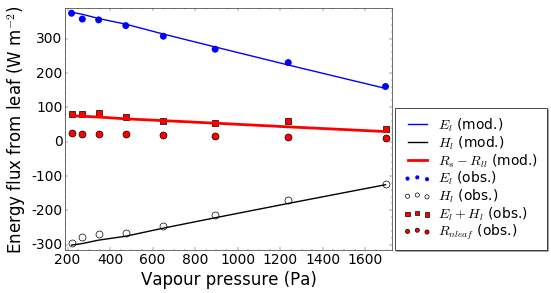

In [19]:
# Fig. 6b
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[g_sw] = 0.035   # According to perforated_foils_LO: range 0.023-0.051
results_orig = fun_results(lc_data, vdict1 = vdict)
results1 = results_orig.copy()
results_35 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + '35_Pwa.eps'

fun_plot_diag(results1, varname1 = 'P_wa', axeslabel1 = 'Vapour pressure (Pa)', Emods = [('E_l', '(mod.)', '-')], Hmods = [('H_l', '(mod.)', '-')], \
              Rmods = [('R_ll', '(mod.)', '-')], esums = True, rll = True, dpi1=50, fname=fname)

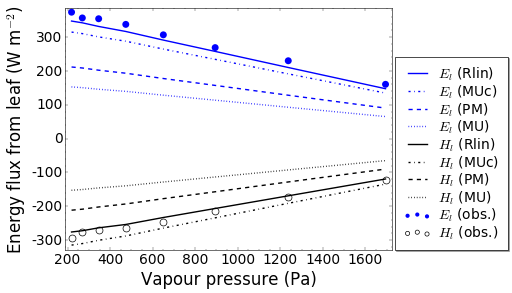

In [20]:
# fig. 7b
fname = path_figs + '35_Pwa_anal.eps'
fun_plot_diag(results1, varname1 = 'P_wa', axeslabel1 = 'Vapour pressure (Pa)', Emods = [('lin_E_l', '(Rlin)', '-'), ('PS_E_l', '(MUc)', '-.'), ('PM_E_l', '(PM)', '--'), ('MU_E_l', '(MU)', ':')], \
              Hmods = [('lin_H_l', '(Rlin)', '-'), ('PS_H_l', '(MUc)', '-.'), ('PM_H_l', '(PM)', '--'), ('MU_H_l', '(MU)', ':')], fname=fname)

## 35.4 holes/mm2, varying wind speed,  Figures 6a and 7a in http://www.hydrol-earth-syst-sci-discuss.net/hess-2016-363/


In [21]:
fname = 'exp_35_4_vw.csv'
lc_data_orig = fun_read_csv(fname, lc_timepos = [])
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_chamber1,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,W/m^2,W/m^2,W/m^2,mV,mV,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-03-27 11:22:28,15.30,15.41,21.98,21.97,21.88,25.24,22.00,21.67,20.29,21.07,18.41,0.8333,10.21,6.827,3.491,2014-03-27 11:22:29,20.30,-0.07058,9.835,-3.912,-13.66,-0.01177,0.004074,0.01766,2014-03-27 11:22:19,2014-03-27 11:22:26,-4.825,0.1412,100,2014-03-27 11:21:28,2014-03-27 11:22:27,1.195,0.0003885,54,"Black leaf, silver perforated alu (35.4-1), varying wind speed"
2014-03-27 13:01:58,15.54,15.65,22.22,22.26,22.22,25.53,22.22,21.95,20.72,21.46,18.72,1.313,10.21,6.427,3.324,2014-03-27 13:02:01,20.41,-0.06664,10.02,-3.833,-16.85,-0.01199,0.003993,0.02180,2014-03-27 13:01:48,2014-03-27 13:01:55,-5.543,0.1600,100,2014-03-27 13:00:59,2014-03-27 13:01:58,1.181,0.0004875,54,varying wind speed
2014-03-27 14:04:25,15.68,15.80,22.41,22.40,22.37,25.69,22.43,22.17,21.05,21.76,18.95,1.796,10.21,6.251,3.274,2014-03-27 14:04:23,20.36,-0.06849,10.02,-3.781,-17.83,-0.01198,0.003939,0.02307,2014-03-27 14:04:10,2014-03-27 14:04:17,-6.124,0.1336,100,2014-03-27 14:03:24,2014-03-27 14:04:23,1.185,0.0003885,54,varying wind speed
2014-03-27 15:55:10,15.74,15.85,22.40,22.42,22.36,25.61,22.42,22.18,21.22,21.85,19.06,2.299,10.21,6.140,3.202,2014-03-27 15:55:11,19.58,-0.09654,9.917,-3.843,-17.14,-0.01187,0.004003,0.02218,2014-03-27 15:55:01,2014-03-27 15:55:08,-6.583,0.1710,100,2014-03-27 15:54:09,2014-03-27 15:55:08,1.169,0.0004755,55,varying wind speed
2014-03-27 17:01:01,15.90,16.02,22.43,22.48,22.40,25.81,22.45,22.22,21.42,21.96,19.24,2.995,10.21,5.851,3.136,2014-03-27 17:01:03,20.03,-0.08036,8.408,-3.625,-16.34,-0.01006,0.003776,0.02114,2014-03-27 17:00:38,2014-03-27 17:00:48,-7.255,0.1174,100,2014-03-27 17:00:04,2014-03-27 17:01:03,1.144,0.0000,54,varying wind speed
2014-03-27 19:00:22,15.88,15.99,22.40,22.38,22.21,25.57,22.46,22.24,21.53,22.03,19.38,3.831,10.20,5.750,3.057,2014-03-27 19:00:26,19.20,-0.1106,8.123,-3.345,-14.00,-0.009719,0.003485,0.01811,2014-03-27 19:00:07,2014-03-27 19:00:17,-8.006,0.1148,100,2014-03-27 18:59:24,2014-03-27 19:00:23,1.155,0.0004130,55,varying wind speed
2014-03-28 10:08:04,15.46,15.57,21.81,21.91,21.85,25.20,21.85,21.67,20.98,21.44,18.93,3.804,10.20,6.147,3.245,2014-03-28 10:08:10,19.58,-0.09655,8.239,-2.960,-12.37,-0.009857,0.003085,0.01600,2014-03-28 10:07:52,2014-03-28 10:08:02,-7.736,0.1666,100,2014-03-28 10:07:07,2014-03-28 10:08:06,1.159,0.0001872,55,New day
2014-03-28 11:29:49,15.71,15.83,22.23,22.21,22.15,25.57,22.24,22.08,21.38,21.84,19.29,4.335,10.20,5.858,3.204,2014-03-28 11:29:51,19.47,-0.1005,8.058,-3.227,-12.36,-0.009641,0.003363,0.01599,2014-03-28 11:29:27,2014-03-28 11:29:37,-7.984,0.08737,100,2014-03-28 11:28:49,2014-03-28 11:29:48,1.174,0.0004692,55,New day
2014-03-28 13:47:28,15.80,15.90,22.35,22.28,22.21,25.57,22.31,22.16,21.54,21.99,19.46,5.102,10.20,5.858,3.131,2014-03-28 13:47:29,19.50,-0.09967,6.985,-3.328,-12.71,-0.008357,0.003468,0.01643,2014-03-28 13:47:18,2014-03-28 13:47:27,-8.505,0.1932,100,2014-03-28 13:46:29,2014-03-28 13:47:28,1.186,0.0004914,54,Reduced head difference (transpiration seemed low)


0.0420000000000000
R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (1187.38813505, 1278.34796382) pascal/P_wa
T_a = (295.0, 296.53) kelvin/T_a
v_w = (0.8333, 5.102) meter/(second*v_w)
g_sw = (0.042, 0.042) meter/(g_sw*second)


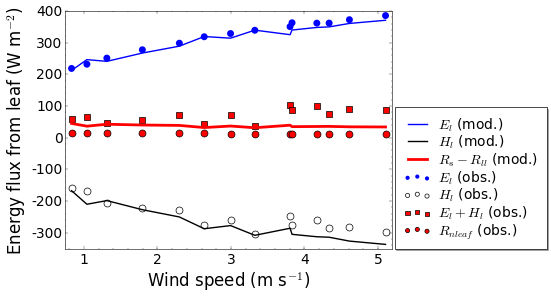

In [22]:
# Fig. 6a
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
#vdict[g_sw] = (0.028+0.051)/2   # According to perforated_foils_LO: range 0.027--0.042
vdict[g_sw] = 0.042
print vdict[g_sw]
results_orig = fun_results(lc_data, vdict)
results1 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))

fname = path_figs + '35_vw.eps'
fun_plot_diag(results1, Emods = [('E_l', '(mod.)', '-')], Hmods = [('H_l', '(mod.)', '-')], \
              Rmods = [('R_ll', '(mod.)', '-')], esums = True, rll = True, dpi1=50, fname=fname)

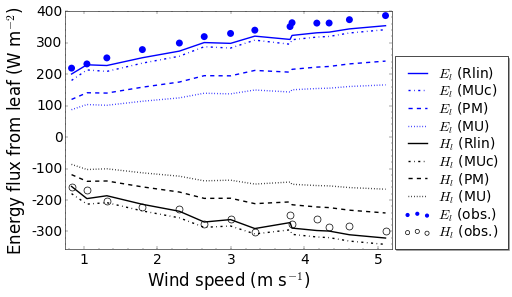

In [23]:
# Fig. 7a
fname = path_figs + '35_vw_anal.eps'
fun_plot_diag(results1, Emods = [('lin_E_l', '(Rlin)', '-'), ('PS_E_l', '(MUc)', '-.'), ('PM_E_l', '(PM)', '--'), ('MU_E_l', '(MU)', ':')], \
              Hmods = [('lin_H_l', '(Rlin)', '-'), ('PS_H_l', '(MUc)', '-.'), ('PM_H_l', '(PM)', '--'), ('MU_H_l', '(MU)', ':')], fname=fname)

## Leaf 7_1,  Figures 6c and 7c 
(in http://www.hydrol-earth-syst-sci-discuss.net/hess-2016-363/)

In [24]:
fname1 = 'new_tunnel_chamber_2Tin_leaf.csv'
fname = path_data + fname1
try:
    reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')
except:
    copyfile(path_data_orig + fname1, fname)
    reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')

nameslist = reader.next()
unitslist = reader.next()
ncols = len(nameslist)
print ncols
print nameslist
print unitslist
csvdata = []
for row in reader :
    row1 = np.array(row)
    # replacing empty fields by NaN
    row1[row1==''] = 'NaN'
    row = tuple(row1)
    csvdata.append(row)

formatslist = []
for i in srange(len(unitslist)):
    if unitslist[i] == '':
        formatslist.append('S100')
    else:
        formatslist.append('float')
data = np.array(csvdata,dtype = zip(nameslist,formatslist))
data_orig = data.copy()

tabledata = []
tabledata.append(list(nameslist))
tabledata.append(list(unitslist))
for i in srange(len(data)):
    line1 = data[i]
    tabledata.append(list(line1) )
#print tabledata
table(tabledata)

18
['Date', 'Time', 'Inflow rate', 'Tdew humidifier', 'Incoming2 Temp_C(5)', 'Incoming3 Temp_C(6)', 'wall inside Temp_C(3) ', 'wall outside Temp_C(4)', 'chamber air Temp_C(1) ', 'Tl1', 'Tl2', 'TlIR', 'Tlin', 'Fan power', 'FlowMeter out', 'Wind speed', 'Sensirion', 'Comment']
['', '', 'l/min', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'W', 'l/min', 'm/s', 'ul/min', '']


Date,Time,Inflow rate,Tdew humidifier,Incoming2 Temp_C(5),Incoming3 Temp_C(6),wall inside Temp_C(3),wall outside Temp_C(4),chamber air Temp_C(1),Tl1,Tl2,TlIR,Tlin,Fan power,FlowMeter out,Wind speed,Sensirion,Comment
,,l/min,oC,oC,oC,oC,oC,oC,oC,oC,oC,oC,W,l/min,m/s,ul/min,
18.02.2014,17:24,,,,,,,,,,,,,,,,"New tunnel with chamber, perforated leaf (7_1) in chamber"
18.02.2014,18:09,,,,,,,,,,,,,,,,NaN
19.02.2014,18:08,,,,,,,,,,,,,,,,lid of TC multiplexer not on!
20.02.2014,11:09,,,,,,,,,,,,,,,,NaN
20.02.2014,13:20,,,,,,,,,,,,,,,,NaN
20.02.2014,13:46,,,,,,,,,,,,,,,,NaN
20.02.2014,14:07,,,,,,,,,,,,,,,,NaN
20.02.2014,14:38,,,,,,,,,,,,,,,,NaN
20.02.2014,14:56,,,,,,,,,,,,,,,,NaN


In [25]:
data.dtype

dtype([('Date', 'S100'), ('Time', 'S100'), ('Inflow rate', '<f8'), ('Tdew humidifier', '<f8'), ('Incoming2 Temp_C(5)', '<f8'), ('Incoming3 Temp_C(6)', '<f8'), ('wall inside Temp_C(3) ', '<f8'), ('wall outside Temp_C(4)', '<f8'), ('chamber air Temp_C(1) ', '<f8'), ('Tl1', '<f8'), ('Tl2', '<f8'), ('TlIR', '<f8'), ('Tlin', '<f8'), ('Fan power', '<f8'), ('FlowMeter out', '<f8'), ('Wind speed', '<f8'), ('Sensirion', '<f8'), ('Comment', 'S100')])

In [26]:
# Identifying the data sets with low and high wind speed
pos_vlow = [3,4,5,6,7,9]
pos_vhigh = [10,11]

R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (168.502255462, 1143.55502295) pascal/P_wa
T_a = (296.05, 296.71) kelvin/T_a
v_w = (0.7, 0.7) meter/(second*v_w)
g_sw = (0.0065, 0.0065) meter/(g_sw*second)


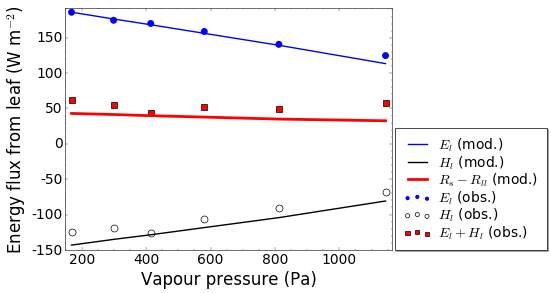

In [27]:
# Fig. 6c
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[g_sw] = 0.0065   # Range: 0.005 to 0.01
ndict = {R_s: '', T_d: 'Tdew humidifier', T_l: 'Tlin', Q_in: 'Fan power', S_a: 'Rn_above_leaf', S_b: 'Rn_below_leaf', S_s: 'Rn_beside_leaf', T_in: 'Incoming2 Temp_C(5)', F_in_v: 'Inflow rate', v_w: 'Wind speed', T_a: 'chamber air Temp_C(1) ', E_lmol: 'Sensirion'}

results_orig = fun_results(data, vdict1=vdict, ndict1=ndict)
results1 = results_orig[pos_vlow]
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + '7_Pwa.eps'
fun_plot_diag(results1, varname1 = 'P_wa', axeslabel1 = 'Vapour pressure (Pa)',  Emods = [('E_l', '(mod.)', '-')], Hmods = [('H_l', '(mod.)', '-')], \
              Rmods = [('R_ll', '(mod.)', '-')], esums = True, rll = True, dpi1=50, fname=fname)

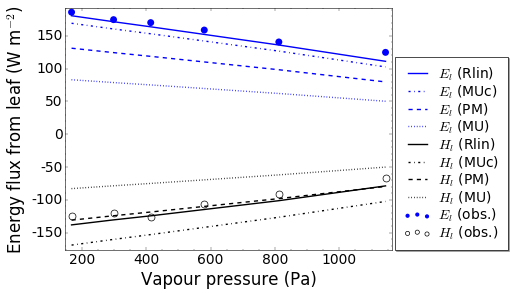

In [28]:
fname = path_figs + '7_Pwa_anal.eps'
fun_plot_diag(results1, varname1 = 'P_wa', axeslabel1 = 'Vapour pressure (Pa)', Emods = [('lin_E_l', '(Rlin)', '-'), ('PS_E_l', '(MUc)', '-.'), ('PM_E_l', '(PM)', '--'), ('MU_E_l', '(MU)', ':')], \
              Hmods = [('lin_H_l', '(Rlin)', '-'), ('PS_H_l', '(MUc)', '-.'), ('PM_H_l', '(PM)', '--'), ('MU_H_l', '(MU)', ':')], fname=fname)

### Comparison of 35 and 7 pores/mm2

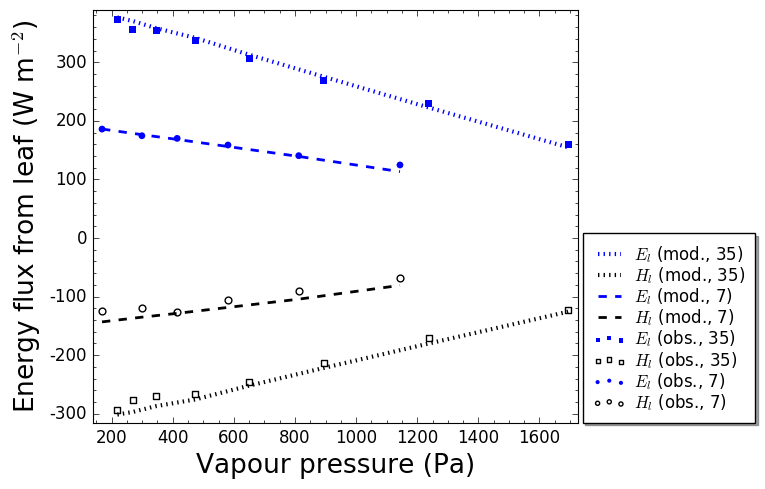

In [29]:
leglength=2
lfsize = 12
axfsize = 18
figsize1 = [6,5]
psize = 24
varname1 = 'P_wa'
axeslabel1 = 'Vapour pressure (Pa)'
Emods = [('E_l', '(mod., 35)', ':')]
Hmods = [('H_l', '(mod., 35)', ':')]
lwidth = 3

# 35 holes data
results2 = results_35.copy()

results2 = np.sort(results2, order = varname1)
pos_vw = srange(len(results2))
xdata = results2[varname1][pos_vw]
Talist = results2['T_a'][pos_vw]

P = list_plot(zip(xdata,results2['Elmeas'][pos_vw]), frame = True, axes = False, plotjoined=False, marker='s', size=psize, legend_label = '$E_l$ (obs., 35)')
for i in srange(len(Emods)):
    tup1 = Emods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['blue'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$E_l$ ' + tup1[1])

    P += list_plot(zip(xdata,results2['Hlmeas'][pos_vw]), marker='s', faceted = True, color = 'white', markeredgecolor = 'black', size=psize, plotjoined=False, legend_label = '$H_l$ (obs., 35)')
for i in srange(len(Hmods)):
    tup1 = Hmods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['black'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$H_l$ ' + tup1[1])


# Now adding 7 pores / mm2
#Emods = [('E_l', '(S-mod.)', '-'), ('El_ball', '(B-mod.)', '--')]
#Hmods = [('H_l', '(S-mod.)', '-'), ('Hl_ball', '(B-mod.)', '--')]
Emods = [('E_l', '(mod., 7)', '--')]
Hmods = [('H_l', '(mod., 7)', '--')]
lwidth = 2

# Sorting array along v_w
results2 = results1.copy()

results2 = np.sort(results2, order = varname1)
pos_vw = srange(len(results2))
xdata = results2[varname1][pos_vw]
Talist = results2['T_a'][pos_vw]

P += list_plot(zip(xdata,results2['Elmeas'][pos_vw]), frame = True, axes = False, plotjoined=False, marker='o', size=psize, legend_label = '$E_l$ (obs., 7)')
for i in srange(len(Emods)):
    tup1 = Emods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['blue'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$E_l$ ' + tup1[1])

    P += list_plot(zip(xdata,results2['Hlmeas'][pos_vw]), marker='o', faceted = True, color = 'white', markeredgecolor = 'black', size=psize, plotjoined=False, legend_label = '$H_l$ (obs., 7)')
for i in srange(len(Hmods)):
    tup1 = Hmods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['black'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$H_l$ ' + tup1[1])



P.axes_labels([axeslabel1, 'Energy flux from leaf (W m$^{-2}$)'])
P.show(fontsize = lfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_handlelength=leglength, legend_loc=(1.01,0.))

# Simulations for varying radiation and air temperature (Fig. 8)
(in http://www.hydrol-earth-syst-sci-discuss.net/hess-2016-363/)

R_s = (0.0, 700.0) joule/(R_s*meter^2*second)
P_wa = (1300.96492908905, 1300.96492908905) pascal/P_wa
T_a = (295, 295) kelvin/T_a
v_w = (1.0, 1.0) meter/(second*v_w)
g_sw = (0.045, 0.045) meter/(g_sw*second)


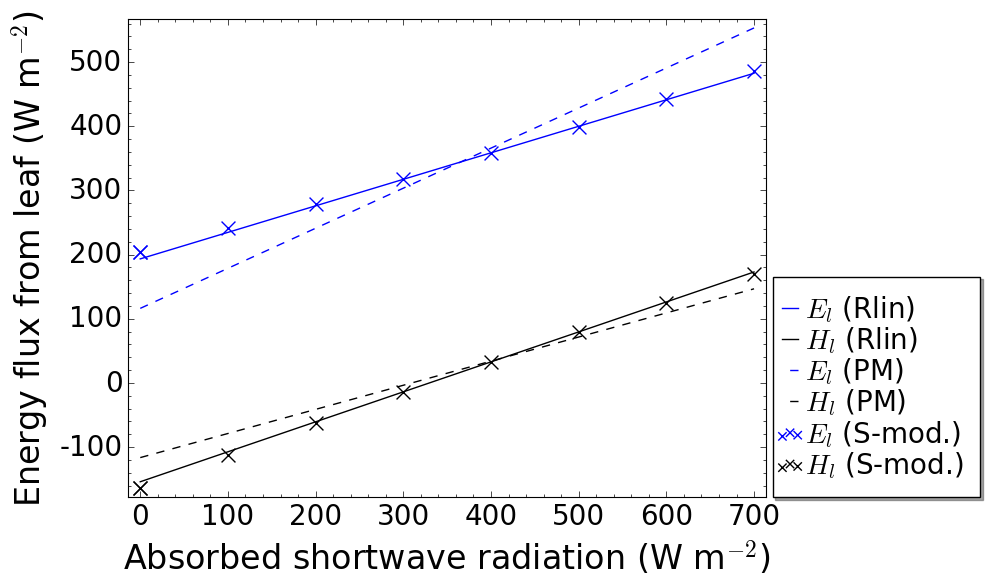

In [30]:
# Fig. 8a
# Conditions similar to experiment with 35.4 holes/mm2
vdict = cdict.copy()
vdict[a_s] = 1.0    # one sided stomata
vdict[g_sw] = 0.045 
vdict[T_a] = 295
vdict[T_w] = vdict[T_a] # Wall temperature equal to air temperature
vdict[P_a] = 101325
rha = 0.5
vdict[P_wa] = rha*eq_Pwl.rhs()(T_l = T_a).subs(vdict)
vdict[L_l] = 0.03
#vdict[L_A] = vdict[L_l]^2
vdict[Re_c] = 3000
vdict[R_s] = 0.
#vdict[Q_in] = 0
vdict[v_w] = 1.0
resdict = fun_SS_PM(vdict)

dict_results = {}

for key1 in resdict.keys():
    dict_results[key1] = [resdict[key1]]



list_Rs = srange(0, 800, 100)

for Rs in list_Rs:
    vdict[R_s] = Rs
    resdict = fun_SS_PM(vdict)

    for key1 in resdict.keys():
        dict_results[key1].append(resdict[key1])

dict_results1 = {}
for key1 in dict_results.keys():
    dict_results1[key1] = np.array(dict_results[key1])
    
results1 = dict_results1.copy()
list_vars = [R_s, P_wa, T_a, v_w, g_sw]
for var1 in list_vars:
    print str(var1) + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[var1]/var1)

xdata = dict_results1[R_s]
vary = [(dict_results1[E_l], 'x', 'blue', '$E_{l}$ (S-mod.)'), (dict_results1[H_l], 'x', 'black', '$H_{l}$ (S-mod.)'), (dict_results1['lin_E_l'], '-', 'blue', '$E_{l}$ (Rlin)'), (dict_results1['lin_H_l'], '-', 'black', '$H_{l}$ (Rlin)'), (dict_results1['PM_E_l'], '--', 'blue', '$E_{l}$ (PM)'), (dict_results1['PM_H_l'], '--', 'black', '$H_{l}$ (PM)')]

fsize = 20
lfsize = 20
axfsize = 1.2
psize = 100
figsize1=[8,6]
xlabel = 'Absorbed shortwave radiation (W m$^{-2}$)'
ylabel = 'Energy flux from leaf (W m$^{-2}$)'
i = 0
P = list_plot(zip(xdata, vary[i][0]), plotjoined=False, marker=vary[i][1], size=psize, faceted = True, color = vary[i][2], legend_label=vary[i][3])
for i in srange(1,2):
    P += list_plot(zip(xdata, vary[i][0]), plotjoined=False, marker=vary[i][1], size=psize, color = vary[i][2], legend_label=vary[i][3])
for i in srange(2,len(vary)):
    P += list_plot(zip(xdata, vary[i][0]), plotjoined=True, linestyle = vary[i][1], color=vary[i][2], legend_label=vary[i][3])
P.axes_labels([xlabel, ylabel])
P.show(fontsize = fsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_loc=(1.01,0))
P.save(path_figs + 'numexp_Rs.png', fontsize = fsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = 14, legend_loc=(1.01,0))

R_s = (350.0, 350.0) joule/(R_s*meter^2*second)
P_wa = (567.937364287074, 567.937364287074) pascal/P_wa
T_a = (282.0, 298.0) kelvin/T_a
v_w = (1.0, 1.0) meter/(second*v_w)
g_sw = (0.045, 0.045) meter/(g_sw*second)


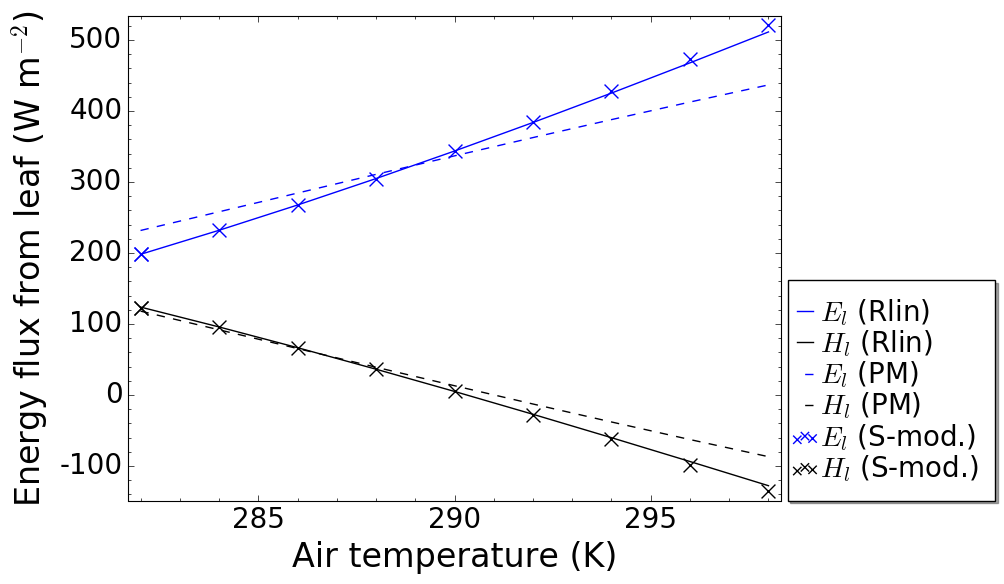

In [31]:
# Fig. 8b
# Conditions similar to experiment with 35.4 holes/mm2, 350 W/m2 irradiance
Tlow = 282.
Thigh = 300.
vdict = cdict.copy()
vdict[a_s] = 1.0    # one sided stomata
vdict[g_sw] = 0.045 
vdict[T_a] = Tlow
vdict[T_w] = vdict[T_a] # Wall temperature equal to air temperature
vdict[P_a] = 101325
rha = 0.5
vdict[P_wa] = rha*eq_Pwl.rhs()(T_l = T_a).subs(vdict)
vdict[L_l] = 0.03
#vdict[L_A] = vdict[L_l]^2
vdict[Re_c] = 3000
vdict[R_s] = 350.
#vdict[Q_in] = 0
vdict[v_w] = 1.0
resdict = fun_SS_PM(vdict)

dict_results = {}

for key1 in resdict.keys():
    dict_results[key1] = [resdict[key1]]



list_Ta = srange(Tlow, Thigh, 2)

for Ta in list_Ta:
    vdict[T_a] = Ta
    vdict[T_w] = vdict[T_a] # Wall temperature equal to air temperature
    resdict = fun_SS_PM(vdict)

    for key1 in resdict.keys():
        dict_results[key1].append(resdict[key1])

dict_results1 = {}
for key1 in dict_results.keys():
    dict_results1[key1] = np.array(dict_results[key1])
    
results1 = dict_results1.copy()
list_vars = [R_s, P_wa, T_a, v_w, g_sw]
for var1 in list_vars:
    print str(var1) + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[var1]/var1)

xdata = dict_results1[T_a]
vary = [(dict_results1[E_l], 'x', 'blue', '$E_{l}$ (S-mod.)'), (dict_results1[H_l], 'x', 'black', '$H_{l}$ (S-mod.)'), (dict_results1['lin_E_l'], '-', 'blue', '$E_{l}$ (Rlin)'), (dict_results1['lin_H_l'], '-', 'black', '$H_{l}$ (Rlin)'), (dict_results1['PM_E_l'], '--', 'blue', '$E_{l}$ (PM)'), (dict_results1['PM_H_l'], '--', 'black', '$H_{l}$ (PM)')]

fsize = 20
lfsize = 20
axfsize = 1.2
psize = 100
figsize1=[8,6]
xlabel = 'Air temperature (K)'
ylabel = 'Energy flux from leaf (W m$^{-2}$)'
i = 0
P = list_plot(zip(xdata, vary[i][0]), plotjoined=False, marker=vary[i][1], size=psize, color = vary[i][2], legend_label=vary[i][3])
for i in srange(1,2):
    P += list_plot(zip(xdata, vary[i][0]), plotjoined=False, marker=vary[i][1], size=psize, color = vary[i][2], legend_label=vary[i][3])
for i in srange(2,len(vary)):
    P += list_plot(zip(xdata, vary[i][0]), plotjoined=True, linestyle = vary[i][1], color=vary[i][2], legend_label=vary[i][3])
P.axes_labels([xlabel, ylabel])
P.show(fontsize = fsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_loc=(1.01,0))
P.save(path_figs + 'numexp_T.png', fontsize = fsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = 14, legend_loc=(1.01,0))